In [ ]:
!nvidia-smi

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

In [32]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='liac-arff')
X = mnist.data
y = mnist.target

X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

mask_train = np.isin(y_train, ['3','4'])
mask_test = np.isin(y_test, ['3','4'])
X_train, y_train = X_train[mask_train], y_train[mask_train]
X_test, y_test = X_test[mask_test], y_test[mask_test]

y_train = y_train.astype(int)
y_test = y_test.astype(int)

y_train[y_train == 3] = 0
y_train[y_train == 4] = 1
y_test[y_test == 3] = 0
y_test[y_test == 4] = 1

pca_train = PCA(n_components=2)
X_pca_train = pca_train.fit_transform(X_train)
X_pca_test = pca_train.transform(X_test)

print(f'X_pca_train: {X_pca_train.shape}')

X_pca_train: (11973, 2)


In [33]:
print(f'y_train: {y_train.shape}')
print(y_train)

y_train: (11973,)
[1 0 1 ... 0 0 0]


1. (10 pts) Implement the logistic regression algorithm to classify the MNIST dataset. Let Pr(C1|x) =
σ(wT x+w0) and Pr(C2|x) = 1−σ(wT x+w0). Learn the parameters w and w0 using the gradient descent
algorithm. Use the maximum number of epochs to be 100 for GD. You can also use any appropriate
convergence criteria to stop the GD loop before 100 epochs. Use a step size of 0.1 (or 0.01 if it is
converging poorly) for GD.

In [34]:
def _shuffle(X, y):
  # shuffles two equal-length list/array, X and Y, together.
  randomize = np.arange(len(X))
  np.random.shuffle(randomize)
  return (X[randomize], y[randomize])

def _sigmoid(z):
  # avoid overflow, minimum/maximum output value is set
  return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1-(1e-8))

def logisticRegression(X, w, b):
  # X: input data, shape = [batch_size, data_dimension]
  # w: weight vector, shape = [data_dimension, ]
  # b: bias, scalar
  return _sigmoid(np.matmul(X, w)+b)

def _accuracy(y_pred, y_label):
  acc = 1 - np.mean(np.abs(y_pred - y_label))
  return acc



In [35]:
def _cross_entropy_loss(y_pred, Y_label):
    # y_pred: probabilistic predictions, float vector
    # Y_label: ground truth labels, bool vector
    # Output:cross entropy, scalar
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # computes the gradient of cross entropy loss with respect to w and b
    y_pred = logisticRegression(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad

In [36]:
train_size = X_pca_train.shape[0]

test_size = X_pca_test.shape[0]
data_dim = X_pca_train.shape[1]

In [ ]:
print(test_size)
print(train_size)

1992
11973


In [37]:
# Zero initialization
w = np.zeros((data_dim,))
b = np.zeros((1,))

max_iter = 100
batch_size = 8
learning_rate = 0.01 #0.01

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
train_acc = []
test_loss = []
test_acc = []

step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_pca_train, y_train = _shuffle(X_pca_train, y_train)

    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_pca_train[idx*batch_size:(idx+1)*batch_size]
        Y = y_train[idx*batch_size:(idx+1)*batch_size]

        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)
        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1

    # Compute loss and accuracy of training set and development set
    y_train_pred = logisticRegression(X_pca_train, w, b)
    Y_train_pred = np.round(y_train_pred) ###########
    train_acc.append(_accuracy(Y_train_pred, y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, y_train) / train_size)

    y_test_pred = logisticRegression(X_pca_test, w, b)
    Y_test_pred = np.round(y_test_pred)
    test_acc.append(_accuracy(Y_test_pred, y_test))
    test_loss.append(_cross_entropy_loss(y_test_pred, y_test) / test_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Test loss: {}'.format(test_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Test accuracy: {}'.format(test_acc[-1]))

<ipython-input-34-206034a59f4d>:9: RuntimeWarning: overflow encountered in exp
  return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1-(1e-8))


Training loss: 0.26672190818309277
Test loss: 0.2114906379698695
Training accuracy: 0.9693476989893928
Test accuracy: 0.9784136546184738


In [ ]:
print(w.shape)
print(X.shape)

(2,)
(8, 2)


2. (3 pts) After the training process, create the following plots:

(a) test error vs the number of epochs
(b) training error vs the number of epochs
(c) test loss vs the number of epochs
(d) training loss vs the number of epochs

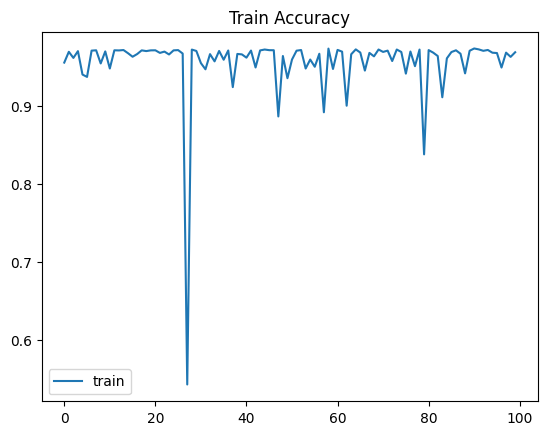

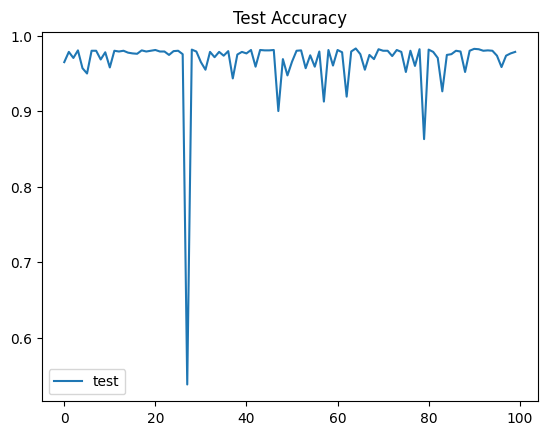

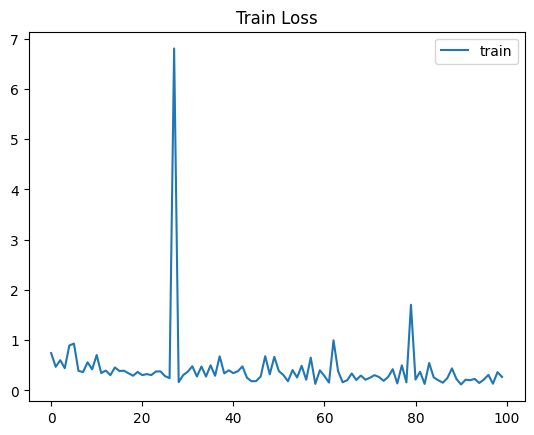

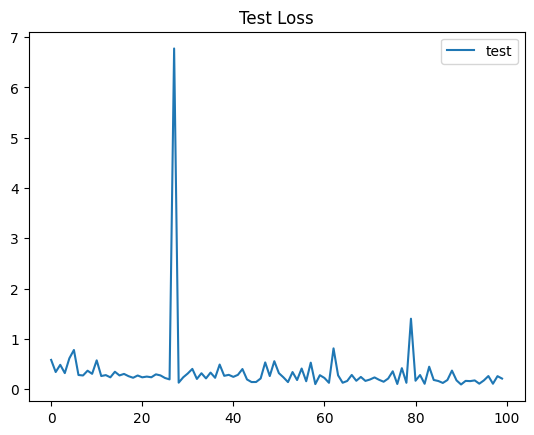

In [38]:
# Accuracy curve
plt.plot(train_acc)
plt.title('Train Accuracy')
plt.legend(['train'])
plt.savefig('train_acc.png')
plt.show()

plt.plot(test_acc)
plt.title('Test Accuracy')
plt.legend(['test'])
plt.savefig('test_acc.png')
plt.show()

# Loss curve
plt.plot(train_loss)
plt.title('Train Loss')
plt.legend(['train'])
plt.savefig('train_loss.png')
plt.show()

plt.plot(test_loss)
plt.title('Test Loss')
plt.legend(['test'])
plt.savefig('test_loss.png')
plt.show()



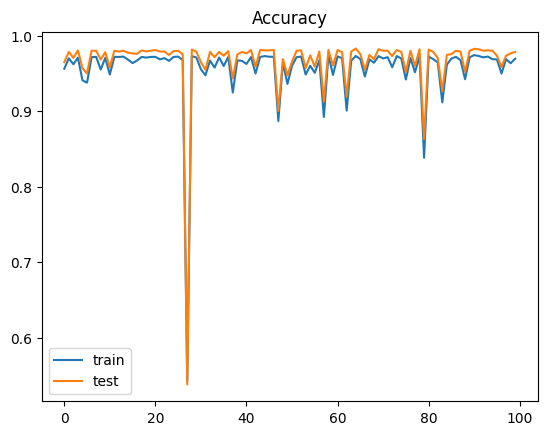

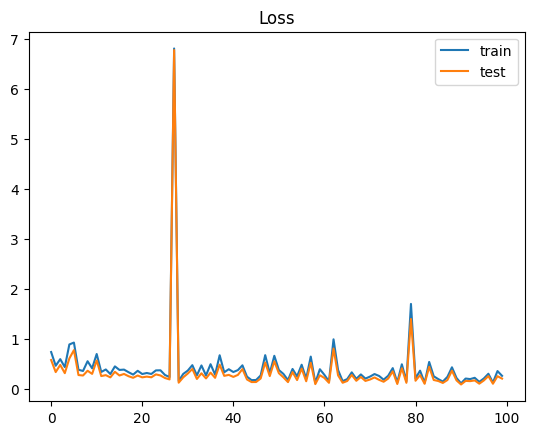

In [39]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.title('Accuracy')
plt.legend(['train', 'test'])
plt.savefig('acc.png')
plt.show()

plt.plot(train_loss)
plt.plot(test_loss)
plt.title('Loss')
plt.legend(['train', 'test'])
plt.savefig('loss.png')
plt.show()

3. (6 pts) Retrain your classifier but without any activation function i.e. no sigmoid at the end. How does
the classifier perform compared to when there is a sigmoid activation? Explain.

In [ ]:
def _shuffle(X, y):
  # shuffles two equal-length list/array, X and Y, together.
  randomize = np.arange(len(X))
  np.random.shuffle(randomize)
  return (X[randomize], y[randomize])

def logisticRegression(X, w, b):
  # X: input data, shape = [batch_size, data_dimension]
  # w: weight vector, shape = [data_dimension, ]
  # b: bias, scalar
  return np.matmul(X, w)+b

def _accuracy(y_pred, y_label):
  acc = 1 - np.mean(np.abs(y_pred - y_label))
  return acc

def _cross_entropy_loss(y_pred, Y_label):
  # y_pred: probabilistic predictions, float vector
  # Y_label: ground truth labels, bool vector
  # Output:cross entropy, scalar
  epsilon = 1e-8
  cross_entropy = -np.dot(Y_label, np.log(y_pred + epsilon)) - np.dot((1 - Y_label), np.log(1 - y_pred + epsilon))
                  #-np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label),           np.log(1 - y_pred))
  return cross_entropy

def _gradient(X, Y_label, w, b):
    # computes the gradient of cross entropy loss with respect to w and b
    y_pred  = logisticRegression(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad

In [ ]:
train_size = X_pca_train.shape[0]
test_size = X_pca_test.shape[0]
data_dim = X_pca_train.shape[1]


In [ ]:
np.round(y_train_pred>0)

array([1., 1., 1., ..., 1., 1., 1.], dtype=float16)

In [ ]:
np.log(y_train_pred + 1e-8)

array([-17.72753356,   0.        , -17.72753356, ...,  -0.02434811,
       -17.72753356,   0.        ])

In [ ]:
# Zero initialization
w = np.zeros((data_dim,))
b = np.zeros((1,))

max_iter = 20
batch_size = 8
learning_rate = 0.1

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
train_acc = []
test_loss = []
test_acc = []

step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_pca_train, y_train = _shuffle(X_pca_train, y_train)

    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_pca_train[idx*batch_size:(idx+1)*batch_size]
        Y = y_train[idx*batch_size:(idx+1)*batch_size]

        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)

        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1

    # Compute loss and accuracy of training set and development set
    y_train_pred = logisticRegression(X_pca_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    # print(f'y_train_pred:{y_train_pred}')
    train_acc.append(_accuracy(Y_train_pred, y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, y_train) / train_size)


    y_test_pred = logisticRegression(X_pca_test, w, b)
    Y_test_pred = np.round(y_test_pred)
    # print(f'y_test_pred:{y_test_pred}')
    test_acc.append(_accuracy(Y_test_pred, y_test))
    test_loss.append(_cross_entropy_loss(y_test_pred, y_test) / test_size)


print('Training loss: {}'.format(train_loss[-1]))
print('Test loss: {}'.format(test_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Test accuracy: {}'.format(test_acc[-1]))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-22-b178355bcd25>:32: RuntimeWarning: invalid value encountered in subtract
  w = w - learning_rate/np.sqrt(step) * w_grad


Training loss: nan
Test loss: nan
Training accuracy: nan
Test accuracy: nan


The classifier without any activation function doesn't perform well and results in NaN values. This is because logistic regression is designed to predict probabilities, which is why we set classes as 0 and 1 and use the sigmoid function.

Without the sigmoid function, the output of the logistic regression can be any real number, which doesn’t make sense in the context of probability prediction. Furthermore, the large output values can cause numerical instability when they are used in subsequent computations, such as the logarithm in the loss function, leading to NaN values.


4. (6 pts) Now let’s fix your bias to any non-zero real value (you can choose 1 for convenience). Keep the
sigmoid activation in the classifier. Repeat the training and testing as in steps 1 and 2. What happens
to the performance of the classifier? Explain.

In [ ]:
def _shuffle(X, y):
  # shuffles two equal-length list/array, X and Y, together.
  randomize = np.arange(len(X))
  np.random.shuffle(randomize)
  return (X[randomize], y[randomize])

def _sigmoid(z):
  # avoid overflow, minimum/maximum output value is set
  return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1-(1e-8))

def logisticRegression(X, w, b):
  # X: input data, shape = [batch_size, data_dimension]
  # w: weight vector, shape = [data_dimension, ]
  # b: bias, scalar
  return _sigmoid(np.matmul(X, w)+b)

def _accuracy(y_pred, y_label):
  acc = 1 - np.mean(np.abs(y_pred - y_label))
  return acc

  def _cross_entropy_loss(y_pred, Y_label):
    # y_pred: probabilistic predictions, float vector
    # Y_label: ground truth labels, bool vector
    # Output:cross entropy, scalar
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # computes the gradient of cross entropy loss with respect to w and b
    y_pred = logisticRegression(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad

In [ ]:
train_size = X_pca_train.shape[0]
test_size = X_pca_test.shape[0]
data_dim = X_pca_train.shape[1]

In [ ]:
# Zero initialization
w = np.zeros((data_dim,))
b = np.ones((1,))

max_iter = 100
batch_size = 8
learning_rate = 0.1 #0.01

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
train_acc = []
test_loss = []
test_acc = []

step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_pca_train, y_train = _shuffle(X_pca_train, y_train)

    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_pca_train[idx*batch_size:(idx+1)*batch_size]
        Y = y_train[idx*batch_size:(idx+1)*batch_size]

        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)
        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1

    # Compute loss and accuracy of training set and development set
    y_train_pred = logisticRegression(X_pca_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_pred, y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, y_train) / train_size)

    y_test_pred = logisticRegression(X_pca_test, w, b)
    Y_test_pred = np.round(y_test_pred)
    test_acc.append(_accuracy(Y_test_pred, y_test))
    test_loss.append(_cross_entropy_loss(y_test_pred, y_test) / test_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Test loss: {}'.format(test_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Test accuracy: {}'.format(test_acc[-1]))

<ipython-input-26-5d78856a0128>:9: RuntimeWarning: overflow encountered in exp
  return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1-(1e-8))


Training loss: 0.428138677694149
Test loss: 0.2965474917626056
Training accuracy: 0.9728555917480999
Test accuracy: 0.981425702811245


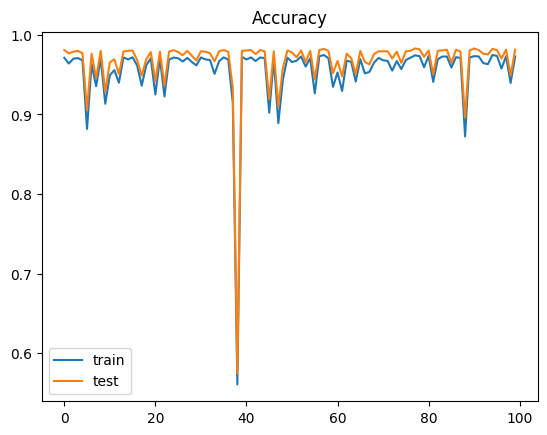

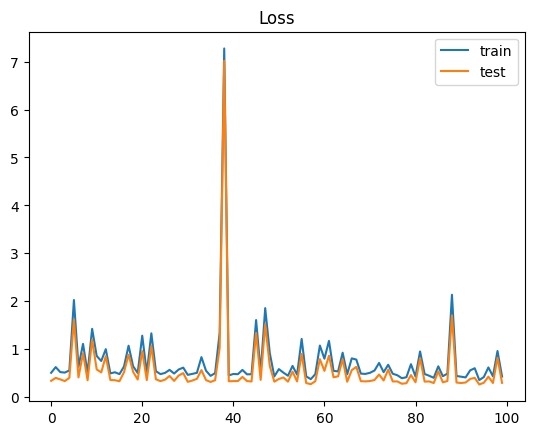

In [ ]:
plt.plot(train_acc)
plt.plot(test_acc)
plt.title('Accuracy')
plt.legend(['train', 'test'])
plt.savefig('acc.png')
plt.show()

plt.plot(train_loss)
plt.plot(test_loss)
plt.title('Loss')
plt.legend(['train', 'test'])
plt.savefig('loss.png')
plt.show()

The result shows that there is an increase in loss, which could be due to the initial shift, but it doesn’t necessarily mean that the model is worse. Changing the bias to 1 allows the decision boundary to shift away from the origin. The accuracy might be slightly affected by this shift in the decision boundary, which could explain why the accuracy doesn’t change significantly. The bias and weights are parameters that are learned during training, so they get updated. Therefore, the initial value is less important than the learning process itself.

5. (5 pts) Compare the final test error with your classifiers in previous exercises (MED, MMD, kNN). Which
classifier performs the best? Why?

All classifiers aim to estimate P(C_1|x) = σ(w · x+b), but they do so differently. Logistic regression, a discriminative model, estimates w and b directly without making assumptions about the data distribution. MED and MMD, generative models, estimate parameters of the class-conditional densities and class priors, which are used to compute w and b. They assume Gaussian distribution or Bernulli or some other distributions. The kNN algorithm, an instance-based learner, classifies based on instance similarity.

According to my previous result, the performance: MMD>MED>kNN. In the logistic regression result, it is not that better than MMD.  While discriminative models often outperform generative models when the decision boundary is complex, generative models can excel when their distributional assumptions hold.